In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torch.nn.utils.rnn as rnn_utils

import torch.nn as nn

from pytorch_metric_learning import losses as ml_losses
from pytorch_metric_learning import miners 
from pytorch_metric_learning.distances import LpDistance

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import gc
import csv

import json
from tqdm import tqdm
from datetime import datetime, date, time, timezone, timedelta
import pickle
import random

import math
from scipy.spatial import distance_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sn
from IPython.display import clear_output
from ipywidgets import Output
from IPython import display

In [2]:
#device = torch.cuda.device(2)
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [3]:
target_players = ['Anders ANTONSEN',
 'Anthony Sinisuka GINTING',
 'CHOU Tien Chen',
 'Jonatan CHRISTIE',
 'Kento MOMOTA',
 'NG Ka Long Angus',
 'Viktor AXELSEN']

In [4]:
def player2cat(player):
    p2c = {'Anders ANTONSEN': 0, 'Anthony Sinisuka GINTING': 1, 'CHOU Tien Chen': 2,
       'Jonatan CHRISTIE': 3, 'Kento MOMOTA': 4, 'NG Ka Long Angus': 5,
       'Viktor AXELSEN': 6}
    return p2c[player]

def cat2player(cat):
    c2p = {0:'ANTONSEN', 1:'GINTING', 2:'CHOU',
       3:'CHRISTIE', 4:'MOMOTA', 5:'NG',
       6:'AXELSEN'}
    return c2p[cat]

def generate_labels(rally_data):
    # predict player A and B
    playerA = rally_data['name_A'].values[0]
    playerB = rally_data['name_B'].values[0]

    if playerA in target_players and playerB in target_players:
        return np.array([player2cat(playerA)]),  np.array([player2cat(playerB)])
    elif playerA not in target_players and playerB in target_players:
        return None,  np.array([player2cat(playerB)])
    elif playerA in target_players and playerB not in target_players:
        return np.array([player2cat(playerA)]),  None
    elif playerA in target_players and playerB in target_players:
        return None,  None

In [5]:
def type2cat(shot_type):
    t2c = {'發短球': 0, '長球': 1, '推球': 2, '殺球': 3, '擋小球': 4, '撲球': 5,
           '平球': 6, '放小球': 7, '挑球': 8, '點扣': 9, '勾球': 10, '過度切球': 11,
           '防守回抽': 12, '防守回挑': 13, '發長球': 14, '切球': 15, '後場抽平球': 16,
           '未知球種': 17, '小平球': 18}
    return t2c[shot_type]

def process_rally(rally_data):
    ## process config
    mean_x, std_x = 630., 160.
    mean_y, std_y = 470., 105.
    
    drop_cols = ['rally', 'ball_round', 'time', 'frame_num', 'db', 'flaw', 'lose_reason', 'win_reason', 'type', 'server', # no need
                 'hit_area', 'landing_area', 'player_location_area', 'opponent_location_area', # area dup with x/y
                 'name_A', 'name_B', 'getpoint_player', 'roundscore_A', 'roundscore_B', # rally-wise features, maybe use later
                 'landing_height', 'landing_x', 'landing_y'] # landing info is dup with hitting
    
    ## Get player name for checking
    playerA = rally_data['name_A'].values[0]
    playerB = rally_data['name_B'].values[0]    
    
    ## process frame_num (time), get frame difference between last shot and this shot, 0 if serve ball 
    frame_diff = np.pad(rally_data['frame_num'].values[1:] - rally_data['frame_num'].values[:-1], (1, 0), mode='constant')
    rally_data['frame_diff'] = frame_diff
    
    ## NaN convert to binary
    rally_data['aroundhead'] = (rally_data['aroundhead'] == 1).astype(int)
    rally_data['backhand'] = (rally_data['backhand'] == 1).astype(int)
    
    ## Player A/B, convert to binary
    rally_data['player'] = (rally_data['player'] == 'A').astype(int)
    
    ## height convert to binary
    rally_data['hit_height'] = (rally_data['hit_height'] -1)
    rally_data['landing_height'] = (rally_data['landing_height'] -1)
    
    ## hit_x, hit_y fill with player location
    rally_data['hit_x'].values[0] = rally_data['player_location_x'].values[0]
    rally_data['hit_y'].values[0] = rally_data['player_location_y'].values[0]
    
    ## x/y standardization
    rally_data['hit_x'] = (rally_data['hit_x'] - mean_x)/std_x
    rally_data['hit_y'] = (rally_data['hit_y'] - mean_y)/std_y
    rally_data['landing_x'] = (rally_data['landing_x'] - mean_x)/std_x
    rally_data['landing_y'] = (rally_data['landing_y'] - mean_y)/std_y
    rally_data['player_location_x'] = (rally_data['player_location_x'] - mean_x)/std_x
    rally_data['player_location_y'] = (rally_data['player_location_y'] - mean_y)/std_y
    rally_data['opponent_location_x'] = (rally_data['opponent_location_x'] - mean_x)/std_x
    rally_data['opponent_location_y'] = (rally_data['opponent_location_y'] - mean_y)/std_y
    
    # type convert to category
    rally_data['type_code'] = [type2cat(t) for t in rally_data['type'].values]
    
    ## drop unneccesary columns
    rally_data.drop(columns=drop_cols, inplace=True)
    
    ## create a copy of the rally but with opposite player 
    inverse = rally_data.copy()
    inverse['player'] = (inverse['player']+1)%2
    
    if playerA in target_players and playerB in target_players:
        return rally_data.values, inverse.values
    elif playerA not in target_players and playerB in target_players:
        return None, inverse.values
    elif playerA in target_players and playerB not in target_players:
        return rally_data.values, None
    elif playerA in target_players and playerB in target_players:
        return None,  None


In [6]:
def collate_fn(data):
    seq, label = zip(*data)
    seq = list(seq)
    label = list(label)
    pairs = [(s, l) for s, l in zip(seq, label)]
    pairs.sort(key=lambda x: len(x[0]), reverse=True)
    seq = [s for s, l in pairs]
    label = [l for s, l in pairs]
    seq_length = [len(sq) for sq in seq]
    seq = rnn_utils.pad_sequence(seq, batch_first=True, padding_value=0)
    labels = torch.zeros(0, 1)
    for l in label:
        labels = torch.cat([labels, l], axis=0)
    return seq, seq_length, labels

In [7]:
data_path = 'aug_set_old.csv'

In [8]:
def check_nan(np_rally):
    if np_rally is None:
        return False
    else:
        return np.isnan(np.sum(np_rally))

In [9]:
data = pd.read_csv(data_path)

rids = set()
# drop flawed rallies, record label distribution
for rally in tqdm(data['rally'].unique()):
    a, b = process_rally(data.loc[data['rally']==rally].copy())
    if data.loc[data['rally']==rally]['flaw'].any() or len(data.loc[data['rally']==rally])<=2 or rally in [578, 596]:
        continue
    else:
        rids.add(rally)

100%|██████████| 2498/2498 [00:17<00:00, 145.26it/s]


In [10]:
def train_test_split(label2rids, test_ratio):
    test = random.sample(label2rids, k=round(len(label2rids)*test_ratio))
    train = [rid for rid in label2rids if rid not in test]
    return train, test

In [11]:
class PlayerClassificationDataset(Dataset):
    def __init__(self, data, rids, split):
        self.data = data
        self.rids = rids
        self.seqs = []
        self.labels = []
        
        pbar = tqdm(rids)
        pbar.set_description('Processing %s rally data'%split)
        tmp = [process_rally(self.data.loc[self.data['rally']==rally].copy()) for rally in pbar]
        for seq1, seq2 in tmp:
            if seq1 is not None:
                self.seqs.append(seq1)
            if seq2 is not None:
                self.seqs.append(seq2)
        
        pbar2 = tqdm(rids)
        pbar2.set_description('Generating %s labels'%split)
        tmp = [generate_labels(self.data.loc[self.data['rally']==rally].copy()) for rally in pbar2]
        for label1, label2 in tmp:
            if label1 is not None:
                self.labels.append(label1)
            if label2 is not None:
                self.labels.append(label2)        
        
        # checking data are clear, remove those with NaN
        self.nan_checking()
    def __len__(self):
        return len(self.seqs)
    
    def __getitem__(self, index):
        return torch.Tensor(self.seqs[index]), torch.Tensor(self.labels[index]).unsqueeze(0)
    
    def nan_checking(self):
        bad_idxs = [idx for idx in range(len(self.seqs)) if check_nan(self.seqs[idx])]
        self.seqs = [seq for idx, seq in enumerate(self.seqs) if idx not in bad_idxs]
        self.labels = [label for idx, label in enumerate(self.labels) if idx not in bad_idxs]
        print("Removed %d rallies with NaN value!"%len(bad_idxs))

In [12]:
class CNNRNN(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, out_dim, GRU_layers):
        super(CNNRNN, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.GRU_layers = GRU_layers
        
        self.type_embedding = nn.Embedding(19, self.embed_dim)
        self.proj = nn.Linear(self.input_dim - 1, self.hidden_dim - self.embed_dim)
        self.fc1 = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        self.conv1 = nn.Conv1d(self.hidden_dim, self.hidden_dim, kernel_size=3, stride=1, padding=1)
        self.GRU = nn.GRU(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.GRU_layers, bias=True, batch_first=True, bidirectional=True)
        self.fc2 = nn.Linear(self.hidden_dim*2, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.out_dim) # in_dim is hidden_dim
        self.relu = nn.ReLU()
        
    def forward(self, seq, seq_length):
        feats = seq[:, :, :-1]
        code = seq[:, :, -1].long()
        embed = self.type_embedding(code)
        feats_proj = self.proj(feats)
        x = torch.cat([feats_proj, embed], axis=-1)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        
#         x = x.permute(0, 2, 1)
#         x = self.conv1(x)
#         x = x.permute(0, 2, 1)
#         x = self.relu(x)
        
        x = rnn_utils.pack_padded_sequence(x, seq_length, batch_first=True, enforce_sorted=False)
        output, h_n = self.GRU(x)
        # output: [batch_size , seq_len, hidden_dim], h_n: [num_layers, batch_size, hidden_dim]
        #x = h_n.permute(1, 0, 2)[:, -1, :]
        out_pad, out_len = rnn_utils.pad_packed_sequence(output, batch_first=True)
        x = out_pad[torch.arange(out_len.shape[0]), out_len-1, :]
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        y = self.output(x)
        return x, y

In [13]:
def metrices(preds, labels, num_classes):
    acc = []
    precision = []
    recall = []
    f1 = []
    count = [] 
    
    TP_all = 0
    FP_all = 0
    TN_all = 0
    FN_all = 0
    for target in range(num_classes):
        cnt = 0
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for i in range(len(preds)):
            if labels[i]==target:
                cnt += 1
            if preds[i]==target and labels[i]==target:
                TP += 1
                TP_all += 1
            elif preds[i]==target and labels[i]!=target:
                FP += 1
                FP_all += 1
            elif preds[i]!=target and labels[i]!=target:
                TN += 1
                TN_all += 1
            elif preds[i]!=target and labels[i]==target:
                FN += 1
                FN_all += 1
        acc.append((TP+TN)/(TP+FP+TN+FN+1e-10))
        precision.append((TP)/(TP+FP+1e-10))
        recall.append(TP/(TP+FN+1e-10))
        f1.append(2*(precision[target]*recall[target])/(precision[target]+recall[target]+1e-10))
        count.append(cnt)
            
    num_exist_class = len([1 for c in count if c!=0]) + 1e-10
    return sum(acc)/num_exist_class, sum(precision)/num_exist_class, sum(recall)/num_exist_class, sum(f1)/num_exist_class, None

def confusion_matrix(preds, labels, num_classes, ax):
    conf = np.zeros((num_classes, num_classes))
    for i in range(len(preds)):
        conf[preds[i]][labels[i]] += 1

    norm_vec = np.sum(conf, axis=0)
    conf = np.around(conf/norm_vec, decimals=2)
    df_cm = pd.DataFrame(conf, [cat2player(i) for i in range(num_classes)], [cat2player(i) for i in range(num_classes)])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap='GnBu', fmt='g', ax=ax)
    b, t = ax.get_ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    ax.set_title("Confusion Matrix of Player Classification")
    ax.set_ylim(b, t) # update the ylim(bottom, top) values
    ax.xaxis.set_tick_params(rotation=45)
    ax.yaxis.set_tick_params(rotation=45)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Prediction')
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    ax.title.set_fontsize(16)


def validation(net, class_embedding, test_loader, num_classes, epoch, ax, conf=False):
    labels = []
    preds = []
    for idx, (seq, seq_length, label) in enumerate(test_loader):
        # seq: [batch x padded length x feat dim]
        # label [batch x 2]
        sigmoid = nn.Sigmoid()
        seq, label = torch.Tensor(seq).cuda(), torch.Tensor(label).long().cuda()
        output,_ = net(seq, seq_length)
        
        pred = torch.argmin(torch.cdist(output, class_embedding, p=2), dim=-1)
        #pred = torch.argmax(output, dim=-1)
        
        labels.append(label.cpu().item())
        preds.append(pred.detach().cpu().item())

    acc, prec, rec, f1, ACC = metrices(preds, labels, num_classes)
    if conf:
        confusion_matrix(preds, labels, num_classes, ax)
    #print("Epoch No.%d\tAcc: %3f, F1: %3f"%(epoch, rec, f1))
    return rec, f1

In [14]:
def moving_average(lst, wind_size):
    lst = [sum(lst[i:i+wind_size])/wind_size for i in range(0, len(lst)-wind_size)]
    return lst

def plots(losses, accs, f1s, wind_size, ax1):
    ax2 = ax1.twinx()
    
    y1 = moving_average(losses, wind_size)
    x1 = [i for i in range(len(y1))]
    
    y2 = accs
    x2_step = round(len(x1)/len(y2))
    x2 = [i*x2_step for i in range(1, len(y2)+1)]
    
    y3 = f1s

    curve1, = ax1.plot(x1, y1, label="Training loss", color='r')
    curve2, = ax2.plot(x2, y2, label="Test accuracy", color='b')
    curve3, = ax2.plot(x2, y3, label="Test F1", color='g')
    
    curves = [curve1, curve2, curve3]
    ax1.legend(curves, [curve.get_label() for curve in curves], loc='center right')
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("Acc/F1")
    
    ax1.set_title("Learning Curve")
    
    for item in ([ax1.xaxis.label, ax1.yaxis.label, ax2.yaxis.label] + ax1.get_xticklabels() + ax1.get_yticklabels() +  ax2.get_yticklabels()):
        item.set_fontsize(12)
    ax1.title.set_fontsize(16)
    

In [15]:
def generate_class_embedding(num_classes, hidden_dim, model, train_loader):
    with torch.no_grad():
        model.eval()
        class_embedding = torch.zeros(num_classes, hidden_dim).cuda()
        class_count = torch.zeros(num_classes).cuda()

        for seq, seq_length, labels in train_loader:
            seq = seq.cuda()

            # labels: [batch_size]
            labels = labels.squeeze(1).long().cuda()
            # output: [batch_size x hidden_dim*2]
            output,_ = model(seq, seq_length)

            # add embeddings to corresponding class_embedding
            #scatter [num_classes x batch_size]
            scatter = torch.zeros(num_classes, labels.shape[0]).cuda()
            scatter[labels, torch.tensor([i for i in range(labels.shape[0])])] = 1

            # add class count
            class_count += scatter.sum(axis=1)

            # scatter*output [num_classes x hidden_dim*2]
            class_embedding += torch.matmul(scatter, output)

        class_embedding /= class_count.unsqueeze(1).expand(num_classes, hidden_dim)
    
    return class_embedding

In [16]:
def generate_all_embedding(num_classes, hidden_dim, model, train_loader):
    with torch.no_grad():
        model.eval()
        embeddings = torch.zeros(0, hidden_dim).cuda()
        classes = torch.zeros(0).long().cuda()

        for seq, seq_length, labels in train_loader:
            seq = seq.cuda()

            # labels: [batch_size]
            labels = labels.squeeze(1).long().cuda()
            # output: [batch_size x hidden_dim*2]
            output,_ = model(seq, seq_length)

            embeddings = torch.cat([embeddings, output], axis=0)
            classes = torch.cat([classes, labels], axis=0)
            
    return embeddings, classes.cpu().numpy()

def tsne_viz(embeddings, labels, ax, set_):
    reduced = TSNE(n_components=2, perplexity=30.0).fit_transform(embeddings)
    
    scatter_x = reduced[:, 0]
    scatter_y = reduced[:, 1]
    group = labels
    cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'cyan', 4: 'magenta', 5: 'yellow', 6: 'black', 7: 'lightgray'}

    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = cat2player(g), s = 2)
    ax.legend()
    ax.set_title('Visualization of Embeddings on %s Set'%set_)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
def tsne_viz_train_test(train_embeddings, train_labels, test_embeddings, test_labels, class_embedding, ax, mode):
    train_range = train_embeddings.shape[0]
    test_range = train_range + test_embeddings.shape[0]
    embeddings = np.concatenate((train_embeddings, test_embeddings, class_embedding), axis=0)
    labels = np.concatenate((train_labels, test_labels, np.array([i for i in range(class_embedding.shape[0])])), axis=0)

    if mode=='tsne':
        reduced = TSNE(n_components=2, perplexity=30.0).fit_transform(embeddings)
    elif mode=='pca':
        reduced = PCA(n_components=2, svd_solver='full').fit_transform(embeddings)
    else:
        raise NotImplemented('Only t-SNE and PCA visualizations are supported currenly')
    
    train_x = reduced[:train_range, 0]
    train_y = reduced[:train_range, 1]
    train_group = labels[:train_range]
    
    test_x = reduced[train_range:test_range, 0]
    test_y = reduced[train_range:test_range, 1]
    test_group = labels[train_range:test_range]
    
    class_x = reduced[test_range:, 0]
    class_y = reduced[test_range:, 1]
    class_group = labels[test_range:]

    
    cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'cyan', 4: 'magenta', 5: 'yellow', 6: 'gray'}

    for g in np.unique(train_group):
        ix = np.where(train_group == g)
        ax.scatter(train_x[ix], train_y[ix], c = cdict[g], s = 4, alpha=0.05)
    
    for g in np.unique(test_group):
        ix = np.where(test_group == g)
        ax.scatter(test_x[ix], test_y[ix], c = cdict[g], label = cat2player(g), s = 10, alpha=0.8)
    
    for g in np.unique(class_group):
        ix = np.where(class_group == g)
        ax.scatter(class_x[ix], class_y[ix], c = cdict[g], s = 200, marker = '*', edgecolors='black')
    
    ax.legend()
    if mode == 'tsne':
        ax.set_title('Visualization of Embeddings (t-SNE)')
    else:
        ax.set_title('Visualization of Embeddings (PCA)')
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

In [17]:
train, test = train_test_split(rids, 0.2)

train_dataset = PlayerClassificationDataset(data, train, 'train')
test_dataset = PlayerClassificationDataset(data, test, 'test')

Processing test rally data:   4%|▍         | 17/402 [00:00<00:02, 168.21it/s]

Removed 2 rallies with NaN value!


Generating test labels: 100%|██████████| 402/402 [00:00<00:00, 2131.39it/s]

Removed 0 rallies with NaN value!


In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=12, collate_fn=collate_fn)

In [19]:
EPOCHS = 1000
num_classes = 7
hidden_dim = 64
lr = 1e-4

In [20]:
net = CNNRNN(12, 32, hidden_dim, num_classes, 2).cuda()
class_embedding = torch.randn(num_classes, hidden_dim).cuda()
class_embedding.require_grad = False

optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)

miner = miners.DistanceWeightedMiner()
loss_func = ml_losses.TripletMarginLoss(margin=0.5, triplets_per_anchor=1)

Output()

  2%|▏         | 24/1000 [02:13<1:31:53,  5.65s/it]

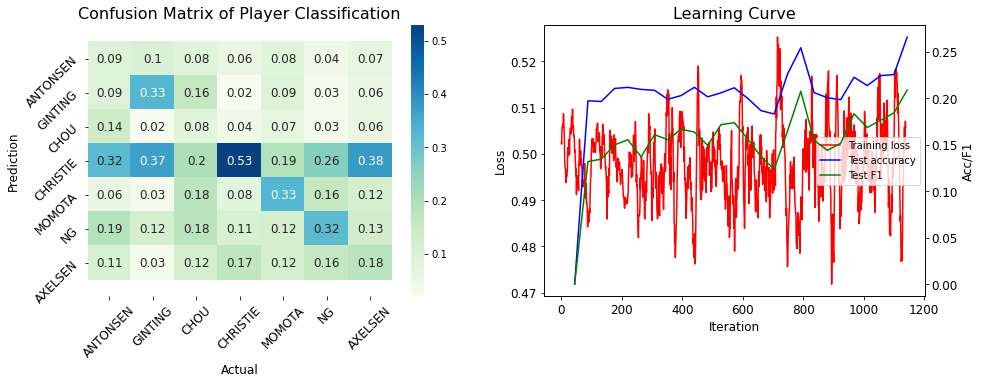

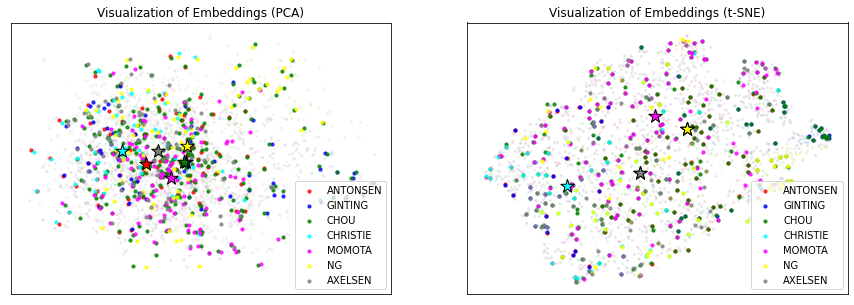

  3%|▎         | 29/1000 [03:00<1:55:05,  7.11s/it]

In [ ]:
out = Output()
display.display(out)

losses = []
accs = [0]
f1s = [0]
gc.collect()

for epoch in tqdm(range(EPOCHS)):
    net.train()
    for data, length, label in train_loader:
        optimizer.zero_grad()
        data = data.cuda()
        label = torch.flatten(label).cuda()
        embedding, _ = net(data, length)
        
#         hard_pairs = miner(embedding, label)        
#         loss = loss_func(embedding, label, hard_pairs)
        
        loss = loss_func(embedding, label)
        
        loss.backward()
        losses.append((loss).item())
        optimizer.step()

    if (epoch+1) % 25 == 0:
        train_embeddings, train_labels = generate_all_embedding(num_classes, hidden_dim, net, train_loader)
        # update dist mtrx
        test_embeddings, test_labels = generate_all_embedding(num_classes, hidden_dim, net, test_loader)
        class_embedding = generate_class_embedding(num_classes, hidden_dim, net, train_loader)
        with out:
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            acc, f1 = validation(net, class_embedding, test_loader, num_classes, epoch, axes[0], conf=True)
            accs.append(acc)
            f1s.append(f1)
            plots(losses, accs, f1s, 10, axes[1])
            plt.show()
            
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
            tsne_viz_train_test(train_embeddings.cpu().numpy(), train_labels, test_embeddings.cpu().numpy(), test_labels, class_embedding.cpu(), axes[0], 'pca')
            tsne_viz_train_test(train_embeddings.cpu().numpy(), train_labels, test_embeddings.cpu().numpy(), test_labels, class_embedding.cpu(), axes[1], 'tsne')
            plt.show()

    else:
        class_embedding = generate_class_embedding(num_classes, hidden_dim, net, train_loader)
        acc, f1 = validation(net, class_embedding, test_loader, num_classes, epoch, ax=None)
        accs.append(acc)
        f1s.append(f1)

In [22]:
# torch.save(net.state_dict(), 'distance_weighted_sampling_margin_loss.pt')